# Import python scripts

In [26]:
# imports.py
%run -i 'imports.py'

# imports.py
%run -i 'preprocessing.py'

# utils.py
%run -i 'utils.py'

# DeltaCon.py
%run -i 'DeltaCon.py'


In [2]:
path = '/Users/Bryan/Documents/Cours_local/MLNS/'
filepath_full_data = path + 'Data/Jan19-31.csv'
savepath = path + 'Data/'

# Preprocessing

## Create a conversion table that maps wallets to a single index

In [3]:
full_df, conversion_df = wal_conversion_table(filepath_full_data, savepath)

  0%|          | 0/8125454 [00:00<?, ?it/s]

Number of sources: 2,022,551
Number of targets: 2,560,511
Number of wallets: 3,112,764


## Preprocess dataframes

In [4]:
# Load conversion table
conversion_df = pd.read_csv(savepath + 'conversion_df.csv')

# Load csv files
Jan19_31 = pd.read_csv(savepath + 'Jan19-31.csv')

In [7]:
Jan19_31_clean = preprocessing(Jan19_31, conversion_df)

In [8]:
Jan19_31_clean

,from_address_idx,to_address_idx,value_eth,gas_price_eth,receipt_gas_used_eth,block_timestamp_true
0,693061,1660284,0.105000,1.731913e-07,1.883960e-13,2022-01-21 01:09:11
1,1393535,1229806,0.030000,1.389635e-07,2.132120e-13,2022-01-21 06:52:46
2,1373817,2340407,0.250000,1.863264e-07,4.503800e-14,2022-01-21 02:16:07
3,1307110,1596705,0.250000,1.439465e-07,9.470600e-14,2022-01-21 18:45:15
4,1943030,482388,0.150000,7.681043e-08,5.221710e-13,2022-01-21 12:26:16
...,...,...,...,...,...,...
8125449,1587629,1014644,0.225500,1.416767e-07,2.100000e-14,2022-01-27 19:42:36
8125450,2345714,2914477,0.033584,1.234891e-07,2.100000e-14,2022-01-27 09:17:38
8125451,795581,2255951,0.300000,1.798086e-07,2.100000e-14,2022-01-27 17:51:02
8125452,2712630,983838,0.540000,2.458474e-07,2.100000e-14,2022-01-27 17:59:38


# Create dataframe for each timeframe

##  Create lists with storing dates as strings and datatimes

In [11]:
x = datetime.strptime('2022-01-20 16:00:00', '%Y-%m-%d %H:%M:%S')

list_timelines = []
list_datetime = []

n = 96

for i in tqdm(range(0, n)):
    dt = x + timedelta(hours=i)
    list_datetime.append(dt)
    list_timelines.append(dt.strftime('%Y-%m-%d %H:%M:%S'))

  0%|          | 0/96 [00:00<?, ?it/s]

In [12]:
# Get the file_names
file_names = []

for i in tqdm(range(0, n)):
    
    dt = list_datetime[i]
    file_names.append('2022_0' + str(dt.month) + '_' + str(dt.day) + '_' + str(dt.hour) + '.csv')

  0%|          | 0/96 [00:00<?, ?it/s]

## Generate csv

In [ ]:
for i in tqdm(range(len(list_timelines)-1)):
    
    # Generate the dataframe
    df = df_full[(df_full['block_timestamp_true'] >= list_timelines[i]) & (df_full['block_timestamp_true'] < list_timelines[i+1])]
    
    # Get the datetimes
    dt = list_datetime[i]
    
    # Generate the names
    name_csv = '2022_0' + str(dt.month) + '_' + str(dt.day) + '_' + str(dt.hour) + '.csv'
    
    # save the csv to the save path
    df.to_csv(savepath+ name_csv, sep = ',', index = False)
    

# Anomaly Detection

## Compute Similarities

In [29]:
similarity = sim_computation(list_timelines)

In [19]:
# create the dataframe
similarities_df = pd.DataFrame(list(zip(list_timelines[:-2], similarity)), 
                               columns =['time', 'similarity'])

In [20]:
# Fill nan values with the mean

similarities_df['similarity'].fillna(value=np.mean(similarities_df['similarity']), inplace=True)

In [ ]:
# Save the dataframe
with open(savepath + 'anomaly_detection/similarities_df.pkl', 'wb') as f:
  pickle.dump(similarities_df, f)

In [24]:
# Load the similarity dataframe

similarities_df = pickle.load(open(savepath +'anomaly_detection/similarities_df.pkl', 
                                   'rb'))

## Plot the observations

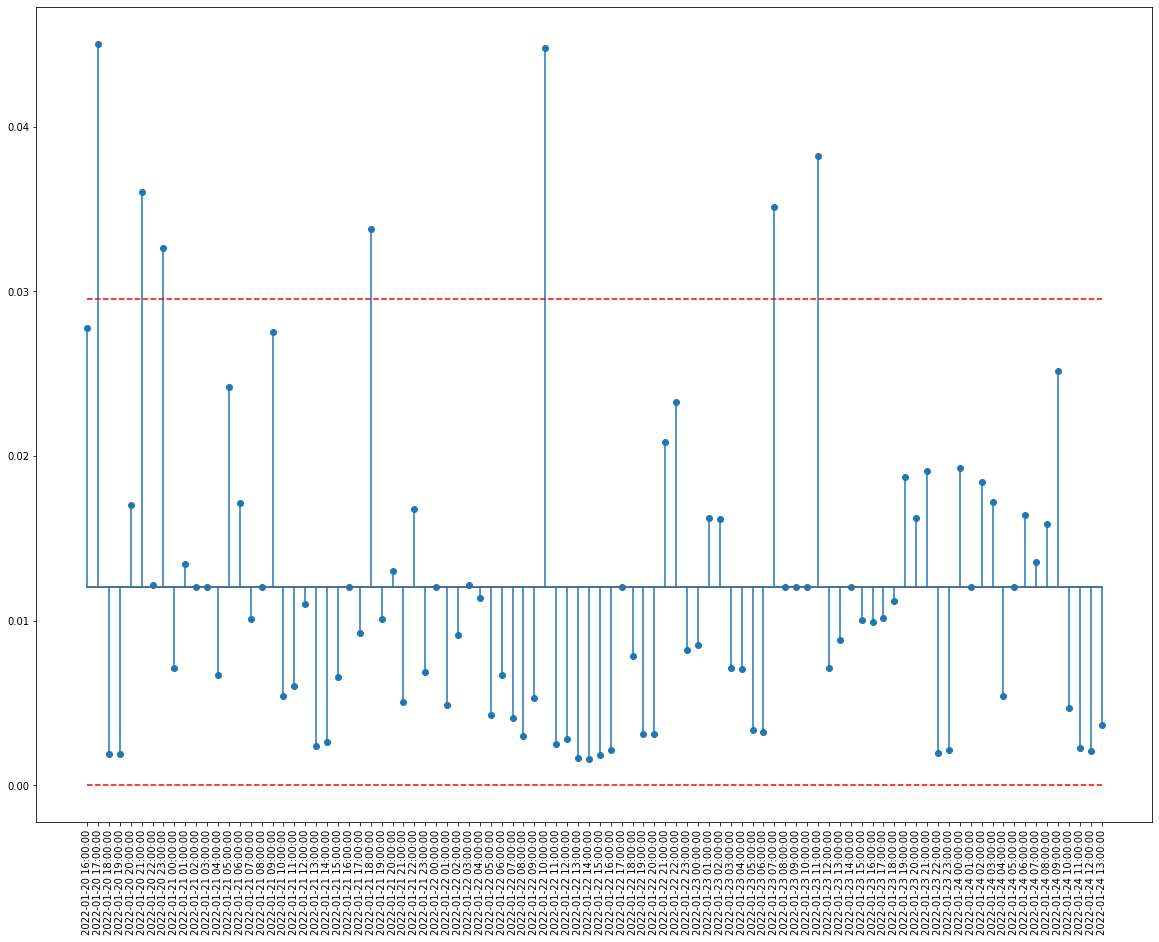

In [27]:
lollipop_chart(similarities_df, k=2)

In [30]:
similarities_df.similarity.describe()

count    94.000000
mean      0.012058
std       0.009747
min       0.001629
25%       0.004917
50%       0.010149
75%       0.016222
max       0.045021
Name: similarity, dtype: float64

# Comments

As shown in cell above, the similarity scores were rather low from one hour to another which is not surprising as Ethereum owners do not transact continuously during normal times. Therefore, we decided to put a threshold for values that are above the normal range of observed values. This threshold (Upper Control Limit) corresponds to median $+ 2\sigma$, similarity scores above this value refers to anomalies as this might denote a possible frenzy in the market.

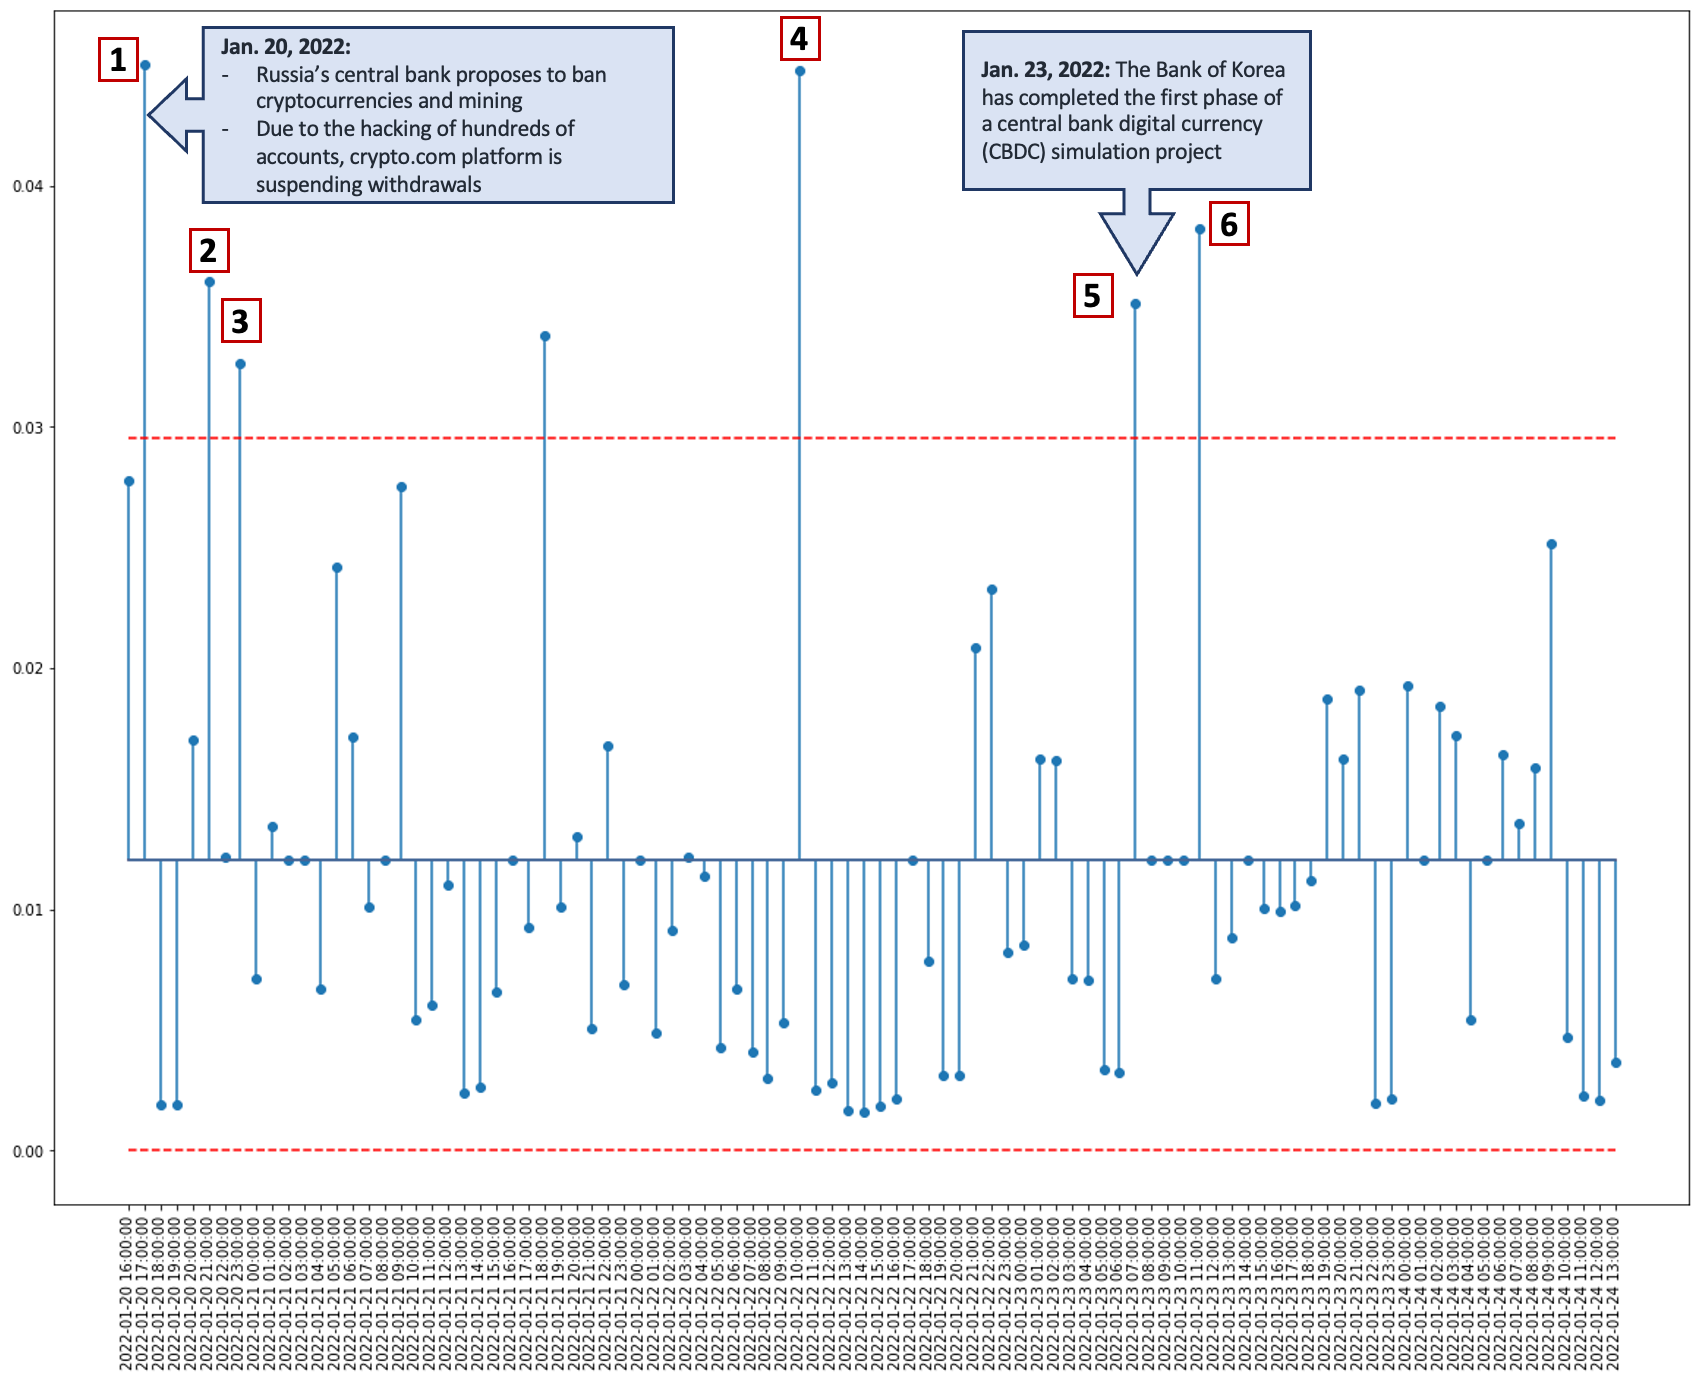

1. 2022-01-20 17:00:00: Start of the crash (-$0.1\%$)
2. 2022-01-20 20:00:00: Large drop in price (-$3.5\%$)
3. 2022-01-20 23:00:00: Large drop in price (-$1.7\%$)
4. 2022-01-22 10:00:00: One of the largest drop in price (-$3.3\%$)
5. 2022-01-23 07:00:00: Small drop in price during the recovery (-$0.1\%$)
6. 2022-01-23 11:00:00: Other small drop in price during the recovery (-$1.5\%$)

Surprisingly, we were able to relate most the anomalous hours to important changes in price and press releases as shown in the Figure 2.